<a href="https://colab.research.google.com/github/jdlg-42/TFG/blob/main/distancias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install igraph
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.6 MB/s eta 0:00:00


# Código para generar grafos de PSN

In [2]:
# Sitios importantes

sites = {
    "A2A_adenosine": [168, 169, 253, 277, 278],
    "A2A_G": [102, 110, 227, 231, 235],
    "beta2AR_epi4ldo": [1113, 1114, 1193, 1203, 1290, 1293, 1312],
    "beta2AR_epi3sn6": [113, 114, 193, 203],
    "beta2AR_G": [131, 134, 135, 136, 138, 139, 142, 222, 226, 229, 233, 236, 239, 271, 274]
    }

Para receptor A2A de adenosina:

* 2YDO: cadena A, sites["A2A_adenosine"], sites["A2A_G"]
* 5G53: cadena A, sites["A2A_adenosine"], sites["A2A_G"]

Para receptor beta-2 adrenérgico:
* 4LDO: cadena A, sites["beta2AR_epi4ldo"], sites["beta2AR_G"]
* 3SN6: cadena R, sites["beta2AR_epi3sn6"], sites["beta2AR_G"]

In [8]:
# Configuración de secuencia y sitios alostérico y ortostérico
  # modificar para analizar el grafo para cada ID específico de interés

pdb_id = "2ydo".lower()
chain_id = "A"
sitio_A = sites["A2A_adenosine"] # sitio de unión del ligando alostérico
sitio_O = sites["A2A_G"] # sitio de unión de la proteína G

[array([-26.785,   4.701,  -7.207], dtype=float32), array([-26.153,   7.952,  -5.306], dtype=float32), array([-22.535,   7.626,  -6.501], dtype=float32), array([-23.812,   8.252, -10.048], dtype=float32), array([-26.502,  10.732,  -8.913], dtype=float32), array([-23.972,  13.029,  -7.195], dtype=float32), array([-21.478,  13.098, -10.092], dtype=float32), array([-24.434,  13.855, -12.379], dtype=float32), array([-25.375,  16.76 , -10.085], dtype=float32), array([-21.88 ,  18.277, -10.177], dtype=float32), array([-22.041,  18.524, -13.99 ], dtype=float32), array([-25.427,  20.271, -13.885], dtype=float32), array([-23.968,  22.982, -11.627], dtype=float32), array([-20.744,  23.21 , -13.666], dtype=float32), array([-22.781,  23.485, -16.89 ], dtype=float32), array([-25.014,  26.165, -15.346], dtype=float32), array([-22.045,  28.143, -13.951], dtype=float32), array([-19.882,  28.071, -17.094], dtype=float32), array([-22.755,  28.909, -19.443], dtype=float32), array([-24.305,  31.615, -17.2

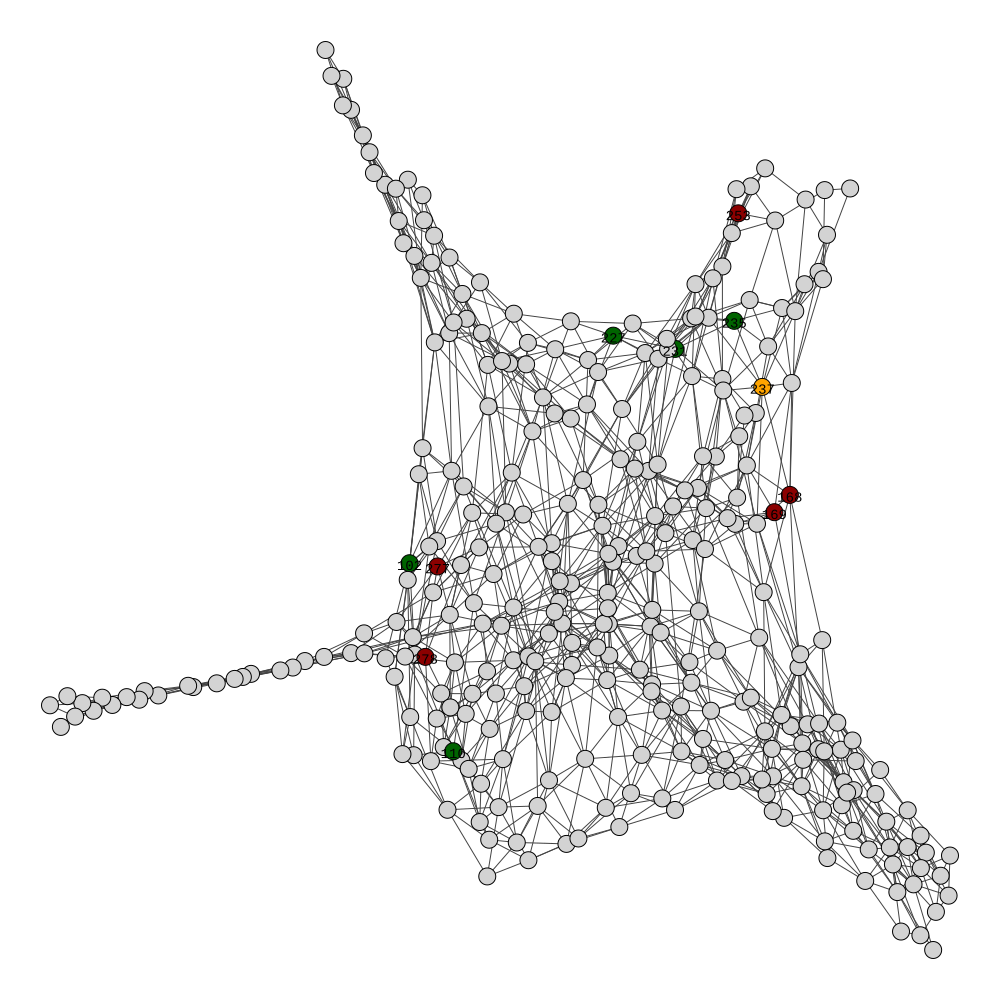

In [11]:
## Grafo de contacto de proteínas ##

# == Comandos de preparación ==

from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)
random.seed(42)

# Configuración de secuencia y

parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# === Extracción de los CA ===
CA_coord = []
for model in structure:
    for chain in model:
      if chain.id == chain_id:
        for residue in chain:
            for atom in residue:
                if atom.get_name() == "CA":
                   CA_coord.append(atom.get_coord())

# === (Opcional) Extracción del ligando ===
alig_list = []
alig_coord = []

# if deseas incluir ligando, descomenta esta sección
# for model in structure:
#     for chain in model:
#         if chain.id != "A":
#             continue
#         for residue in chain:
#             if residue.get_resname() == "ADN" and residue.id[1] == 400:
#                 for atom in residue:
#                     alig_list.append(atom.get_id())
#                     alig_coord.append(atom.get_coord())

atom_coord = CA_coord + alig_coord
print(atom_coord)

# === Árbol de búsqueda y pares ===
tree = cKDTree(atom_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(atom_coord[i] - atom_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Cálculo de caminos más cortos ===
shortest_paths = []  # Lista para almacenar todos los caminos más cortos y sus colores
colors = ["gold", "blue", "green", "purple", "orange", "cyan"]  # Lista de colores que se asignarán a los caminos

# Cálculo de los caminos más cortos
for a in sitio_A:
    for o in sitio_O:
        try:
            path = g.get_shortest_paths(a, to=o)[0]
            if path:
                shortest_paths.append({
                    "path": path,
                    "length": len(path),
                    "color": colors[len(shortest_paths) % len(colors)],  # Asignar un color por cada camino
                    "nodes": (a, o)
                })
        except:
            continue

# === Grafo ===
g = ig.Graph()
g.add_vertices(len(atom_coord))
for i, j in atom_pairsfilt:
    g.add_edge(i, j)

g.vs["size"] = 17
g.vs["color"] = ["lightgray"]
g.vs["label"] = [None] * len(g.vs)

# === Ligando ===
lig_start_idx = len(CA_coord)
lig_end_idx = lig_start_idx + len(alig_coord)
for i in range(lig_start_idx, lig_end_idx):
    g.vs[i]["color"] = "navy"
    g.vs[i]["label"] = alig_list[i - lig_start_idx]

shortest_paths.sort(key=lambda x: x["length"])

# === Asignación de colores a los caminos más cortos ===
for idx, path_info in enumerate(shortest_paths):
    color = path_info["color"]
    path = path_info["path"]
    # Imprimir la información de cada shortest path
    print(f"Caminos más cortos entre los nodos {path_info['nodes']} (color: {color}):")
    print(f"Índice: {idx+1}")
    print(f"  Nodos involucrados: {path}")
    print(f"  Longitud del camino: {path_info['length']}")
    print(f"  Color asignado: {color}")
    print("="*50)

# === Preguntar al usuario qué camino desea visualizar ===
try:
    selection = int(input("Introduce el número del camino más corto que deseas visualizar (0 para no representar ninguno): "))
    if 1 <= selection <= len(shortest_paths):
        chosen_path = shortest_paths[selection - 1]
        path = chosen_path["path"]
        color = chosen_path["color"]

        for node in path:
            g.vs[node]["color"] = color
            g.vs[node]["label"] = str(node)
    else:
        print("Número fuera de rango. No se coloreará ningún camino.")
except ValueError:
    print("Entrada no válida. No se coloreará ningún camino.")


# === Sitios de interés (debes definir previamente el diccionario 'sites') ===
for aa in sitio_A:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkred"
        g.vs[aa]["label"] = str(aa)

for aa in sitio_O:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkgreen"
        g.vs[aa]["label"] = str(aa)

# === Plot ===
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1000, 1000), margin=50)